In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from scipy.stats import pearsonr

def evaluate_regression(y_test, y_pred, plot=True):
    """
    Compare regression predictions (y_pred) against true values (y_test).
    
    Args:
        y_test (array): True target values.
        y_pred (array): Predicted values.
        plot (bool): Whether to generate plots.
    
    Returns:
        dict: Metrics and plots.
    """
    # Calculate metrics
    metrics = {
        'MAE': mean_absolute_error(y_test, y_pred),
        'RMSE': np.sqrt(mean_squared_error(y_test, y_pred)),
        'R2': r2_score(y_test, y_pred),
        'Correlation': pearsonr(y_test, y_pred)[0],
        'Mean Absolute % Error': np.mean(np.abs((y_test - y_pred) / y_test)) * 100,
        'directional_accuracy': np.sum((np.diff(y_test) * np.diff(y_pred)) > 0) / (len(y_test) - 1) * 100
    }
    
    # Plot results
    if plot:
        plt.figure(figsize=(12, 5))
        
        # Plot 1: Actual vs Predicted
        plt.subplot(1, 2, 1)
        plt.scatter(y_test, y_pred, alpha=0.5)
        plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--')
        plt.xlabel('Actual Price')
        plt.ylabel('Predicted Price')
        plt.title('Actual vs Predicted')
        
        # Plot 2: Residuals
        plt.subplot(1, 2, 2)
        residuals = y_test - y_pred
        plt.hist(residuals, bins=30, edgecolor='black')
        plt.axvline(x=0, color='r', linestyle='--')
        plt.xlabel('Residuals (Actual - Predicted)')
        plt.title('Residual Distribution')
        
        plt.tight_layout()
        plt.show()
    
    return metrics

In [85]:
from core.data_loader import DataLoader
import os
import sys
from core.backtester import Backtester
from strategies.atr_breakout import ATRTrailingBreakout
from strategies.multi_momentum import MultiTimeframeMomentum
from strategies.vwap_reversion import VWAPReversion
from strategies.bb_rsi import BB_RSI
import logging
from datetime import datetime
import pandas as pd

# Налаштування логування
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

# Завантаження даних
loader = DataLoader()
data_file = 'btc_1m_apr25_askbid.parquet'
if os.path.exists(os.path.join('data', data_file)):
    logger.info("Завантаження даних...")
    df = loader.fetch_historical_bid_ask('SOLBTC', '1m', start_date='2025-04-01', end_date='2025-05-01')
else:
    df = loader.load_data(data_file)
df

INFO:__main__:Завантаження даних...


,open,high,low,close,volume,bid,ask
timestamp,,,,,,,
2025-04-01 00:00:00,2.800000e-07,2.800000e-07,2.800000e-07,2.800000e-07,0.0,2.700000e-07,2.900000e-07
2025-04-01 00:01:00,2.800000e-07,2.800000e-07,2.800000e-07,2.800000e-07,350.0,2.700000e-07,2.900000e-07
2025-04-01 00:02:00,2.800000e-07,2.800000e-07,2.800000e-07,2.800000e-07,0.0,2.700000e-07,2.900000e-07
2025-04-01 00:03:00,2.800000e-07,2.800000e-07,2.800000e-07,2.800000e-07,0.0,2.700000e-07,2.900000e-07
2025-04-01 00:04:00,2.800000e-07,2.800000e-07,2.800000e-07,2.800000e-07,0.0,2.700000e-07,2.900000e-07
...,...,...,...,...,...,...,...
2025-04-11 14:04:00,2.700000e-07,2.700000e-07,2.700000e-07,2.700000e-07,0.0,2.600000e-07,2.800000e-07
2025-04-11 14:05:00,2.700000e-07,2.700000e-07,2.700000e-07,2.700000e-07,0.0,2.600000e-07,2.800000e-07
2025-04-11 14:06:00,2.700000e-07,2.700000e-07,2.700000e-07,2.700000e-07,0.0,2.600000e-07,2.800000e-07


In [86]:
# Create sequences (sliding window)
sequence_length = 50  # Use past 50 candles to predict future
N = 5 
X, y = [], []

for i in range(len(df) - sequence_length - N):
    X.append(df['close'][i:i+sequence_length])  # Input: Past 50 candles (OHLCV) not included
    y.append(df['close'].iloc[i+sequence_length + N])  # Target: Future close price included

X = np.array(X)
y = np.array(y)

# Train-test split (time-series aware)
split = int(0.5 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]
print(X_test.shape)
y_test

(7597, 50)


array([2.6e-07, 2.6e-07, 2.6e-07, ..., 2.7e-07, 2.7e-07, 2.7e-07])

In [87]:
df['close'].iloc[-2]

np.float64(2.7e-07)

In [88]:
X_test

array([[2.7e-07, 2.7e-07, 2.7e-07, ..., 2.6e-07, 2.6e-07, 2.6e-07],
       [2.7e-07, 2.7e-07, 2.7e-07, ..., 2.6e-07, 2.6e-07, 2.6e-07],
       [2.7e-07, 2.7e-07, 2.7e-07, ..., 2.6e-07, 2.6e-07, 2.6e-07],
       ...,
       [2.6e-07, 2.6e-07, 2.6e-07, ..., 2.7e-07, 2.7e-07, 2.7e-07],
       [2.6e-07, 2.6e-07, 2.6e-07, ..., 2.7e-07, 2.7e-07, 2.7e-07],
       [2.6e-07, 2.6e-07, 2.6e-07, ..., 2.7e-07, 2.7e-07, 2.7e-07]])

In [ ]:
y_test

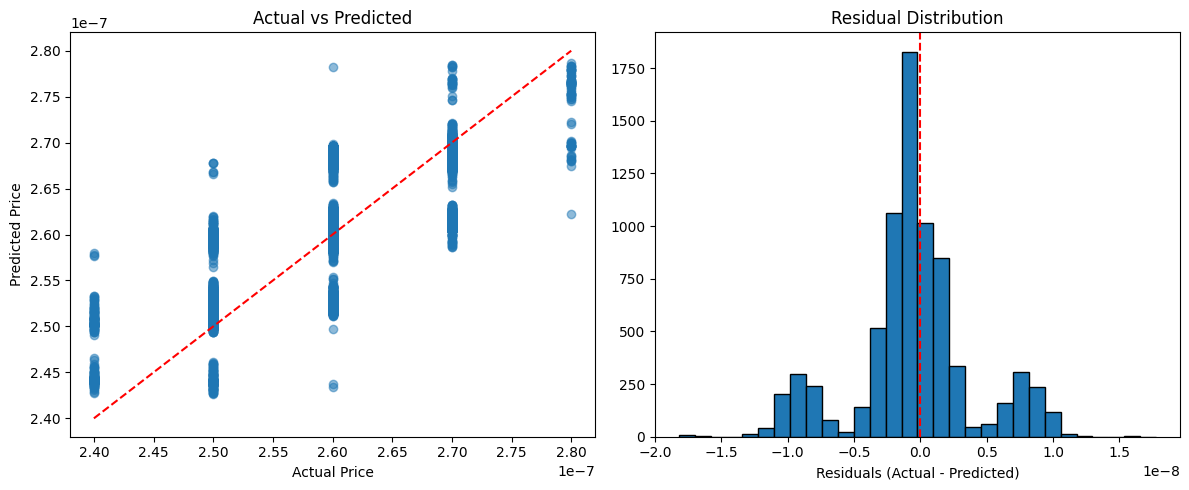

{'MAE': 3.127183297689732e-09, 'RMSE': np.float64(4.504309231935182e-09), 'R2': 0.6622431273147017, 'Correlation': np.float64(0.8166861423518093), 'Mean Absolute % Error': np.float64(1.210549939212898), 'directional_accuracy': np.float64(3.0937335439705107)}


In [89]:
# Import required libraries
from sklearn.linear_model import LinearRegression

# Create and train the model
model = LinearRegression()
model.fit(X_train.reshape(X_train.shape[0], -1), y_train)

# Make predictions
y_pred = model.predict(X_test.reshape(X_test.shape[0], -1))

# Print evaluation metrics
metrics = evaluate_regression(y_test, y_pred)
print(metrics)


In [91]:
print(y_test.shape)
print(y_pred.shape)

(7597,)
(7597,)


In [92]:
def evaluate_trading_strategy(actual_current_price, predicted_future_price, actual_future_price):
    """
    Evaluate trading strategy using vectorbt
    
    Args:
        actual_current_price: Current price series
        predicted_future_price: Predicted future price series 
        actual_future_price: Actual future price series for backtesting
        
    Returns:
        dict: Trading performance metrics
    """
    # Import vectorbt
    import vectorbt as vbt
    
    # Generate long signals when predicted price is higher than current price + 0.5%
    long_signals = pd.Series(predicted_future_price > actual_current_price * 1.005).astype(int)
    
    # Generate short signals when predicted price is lower than current price - 0.5%  
    short_signals = pd.Series(predicted_future_price < actual_current_price * 0.995).astype(int)
    
    # Combine signals: 1 for long, -1 for short, 0 for no position
    signals = long_signals - short_signals

    # Create portfolio simulation
    pf = vbt.Portfolio.from_signals(
        actual_future_price,
        entries=signals == 1,  # Long entries
        exits=signals == -1,  # Short entries
        fees=0.001,
        slippage=0.0005,
        freq='1m'  # Assuming minute data
    )

    # Get trading results
    results = pf.stats()
    
    print("\nTrading Results:")
    print(f"Total Return: {results['Total Return [%]']}%")
    print(f"Sharpe Ratio: {results['Sharpe Ratio']}")
    print(f"Max Drawdown: {results['Max Drawdown [%]']}%") 
    print(f"Win Rate: {results['Win Rate [%]']}%")
    print(f"Expectancy: {results['Expectancy']}")
    print(f"Avg Winning Trade Duration: {results['Avg Winning Trade Duration']}")
    print(f"Avg Losing Trade Duration: {results['Avg Losing Trade Duration']}")
    
    return results

# Example usage:
actual_current_price = y_test[:-N]
predicted_future_price = y_pred[N:]
actual_future_price = y_test[N:]

results = evaluate_trading_strategy(actual_current_price, predicted_future_price, actual_future_price)



Trading Results:
Total Return: 811.0263982656182%
Sharpe Ratio: 31.521839983935603
Max Drawdown: 14.141190686983984%
Win Rate: 40.7563025210084%
Expectancy: 3.4076739422925133
Avg Winning Trade Duration: 0 days 00:21:12.989690721
Avg Losing Trade Duration: 0 days 00:13:40


In [99]:
# Import vectorbt
import vectorbt as vbt

# Define trading parameters
initial_balance = 10000  # Starting capital in USD
position_size = 0.1  # Use 10% of balance per trade
stop_loss = 0.02  # 2% stop loss
take_profit = 0.03  # 3% take profit
# Convert predictions and actual prices to pandas Series

actual_current_price = y_test[:-N - 50]
predicted_future_price = y_pred[N:]
actual_future_price = y_test[N:-50]
# Generate long signals when predicted price is higher than current price + 0.5%
long_signals = pd.Series(predicted_future_price > actual_current_price * 1.005).astype(int)
# Generate short signals when predicted price is lower than current price - 0.5%  
short_signals = pd.Series(predicted_future_price < actual_current_price * 0.995).astype(int)
# Combine signals: 1 for long, -1 for short, 0 for no position
signals = long_signals - short_signals

# Create portfolio simulation
pf = vbt.Portfolio.from_signals(
    actual_future_price,
    entries=signals == 1,  # Long entries
    exits=signals == -1,  # Short entries
    # init_cash=initial_balance,
    fees=0.001,
    slippage=0.0005,
    # sl_stop=stop_loss,  # Stop loss percentage 
    # tp_stop=take_profit,  # Take profit percentage
    freq='1m'  # Assuming daily data
)

print(signals.value_counts())
# Print trading results
print("\nTrading Results:")
results = pf.stats()
print(f"Total Return: {results['Total Return [%]']}%")
print(f"Sharpe Ratio: {results['Sharpe Ratio']}")
print(f"Max Drawdown: {results['Max Drawdown [%]']}%")
print(f"Win Rate: {results['Win Rate [%]']}%")
print(f"Expectancy: {results['Expectancy']}")
print(f"Avg Winning Trade Duration: {results['Avg Winning Trade Duration']}")
print(f"Avg Losing Trade Duration: {results['Avg Losing Trade Duration']}")


 0    3895
 1    1833
-1    1814
Name: count, dtype: int64

Trading Results:
Total Return: 539.7378124180296%
Sharpe Ratio: 27.490921883962645
Max Drawdown: 8.92086391374894%
Win Rate: 54.95495495495496%
Expectancy: 4.8711508018519165
Avg Winning Trade Duration: 0 days 00:48:09.836065573
Avg Losing Trade Duration: 0 days 00:18:36


In [100]:
pf.plot().show()